In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import json

In [2]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors

RDKit WARNING: [13:36:21] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
# Set the default renderer to png as the data is huge and overwhelms the Javascript renderers
pio.renderers.default = 'png'

## Generate distances to active site points

In [4]:
# Run distance_finder.py to add distances to the points defined in points.txt
# This only needs doing once!

%run distance_finder.py -i Mpro_16_data.sdf.gz -p points.txt -o Mpro_16_data_dist.sdf

XChem distances args:  Namespace(input='Mpro_16_data.sdf.gz', outfile='Mpro_16_data_dist.sdf', points='points.txt')
Read points ['5.655', '1.497', '18.223']
Read points ['1.494', '-8.367', '18.574']
Read points ['13.034', '6.306', '25.232']
Read points ['8.543', '-0.647', '20.479']
Read points ['14.208', '5.879', '21.170']
Read points ['13.698', '-1.733', '22.648']
Read points ['5.425', '-5.764', '22.061']
Read points ['6.962', '-6.805', '29.414']
Found 8 atom points
Wrote 41582 molecules


## Read the data frame

In [5]:
# Currently can't work out how to read the pickle correctly so we read the SDF instead
df = PandasTools.LoadSDF('./Mpro_16_data_dist.sdf', molColName='Molecule')
df.shape

(41582, 21)

In [6]:
df.dtypes

Target                        object
TransFSScore                  object
SCORE                         object
SCORE.norm                    object
Max_SuCOS_Score               object
Max_SuCOS_FeatureMap_Score    object
Max_SuCOS_Protrude_Score      object
Max_SuCOS_Index               object
Cum_SuCOS_Score               object
Cum_SuCOS_FeatureMap_Score    object
Cum_SuCOS_Protrude_Score      object
distance1                     object
distance2                     object
distance3                     object
distance4                     object
distance5                     object
distance6                     object
distance7                     object
distance8                     object
ID                            object
Molecule                      object
dtype: object

## Fix column types and names

In [7]:
# So we need to fix all the column types again!

df = df.astype(dtype= {
    "Cum_SuCOS_FeatureMap_Score":"float64",
    "Cum_SuCOS_Protrude_Score":"float64",
    "Cum_SuCOS_Score":"float64",
    "Max_SuCOS_Index":"float64",
    "Max_SuCOS_FeatureMap_Score":"float64",
    "Max_SuCOS_Protrude_Score":"float64",
    "Max_SuCOS_Score":"float64",
    "SCORE":"float64",
    "SCORE.norm":"float64",
    "TransFSScore":"float64",
    "distance1":"float64",
    "distance2":"float64",
    "distance3":"float64",
    "distance4":"float64",
    "distance5":"float64",
    "distance6":"float64",
    "distance7":"float64",
    "distance8":"float64"
})
df =  df.astype(dtype= {
    "Max_SuCOS_Index":"int64",
})

df = df.rename(columns={"ID": "NSMILES"})


In [8]:
# This methods provides a simple way to re-order columns.
# See https://towardsdatascience.com/reordering-pandas-dataframe-columns-thumbs-down-on-standard-solutions-1ff0bc2941d5

def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

In [9]:
# Re-order colums to be more friendly

df = movecol(df, 
             cols_to_move=['NSMILES','Molecule','Target'], 
             ref_col='TransFSScore',
             place='Before')

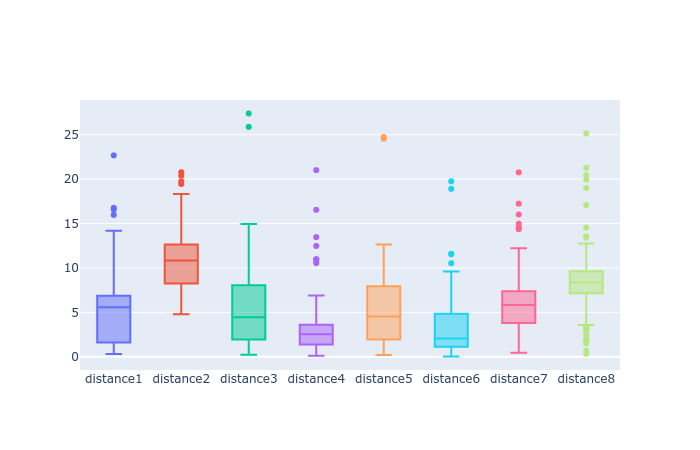

In [10]:
# plot all distance dsitributions

fig = go.Figure()
for i in range(1,9):
    k = "distance" + str(i)
    xs = []
    for i in range(500):
        xs.append(k)
    fig.add_trace(go.Box(x=xs, y=df[k], showlegend=False))
fig.show()

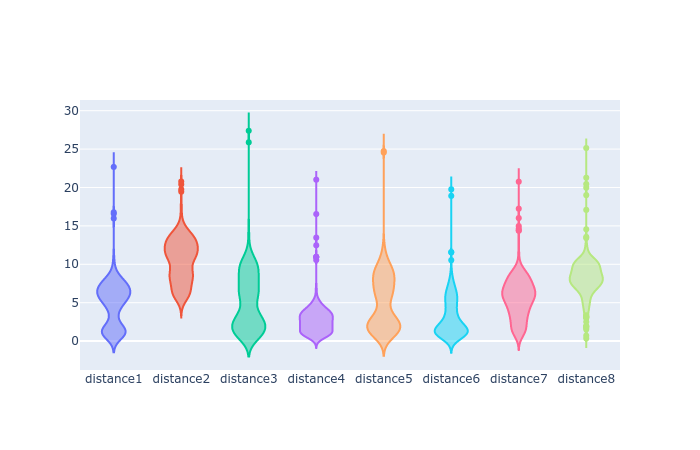

In [11]:
# the same as a violin plot

fig = go.Figure()
for i in range(1,9):
    k = "distance" + str(i)
    xs = []
    for i in range(500):
        xs.append(k)
    fig.add_trace(go.Violin(x=xs, y=df[k], showlegend=False))
fig.show()

Nothing is close to site 2.

Site 8 is poorly occupied.

## Calculate molecular properties

In [12]:
df['logP'] = df['Molecule'].apply(lambda mol: Descriptors.MolLogP(mol))
df['rotb'] = df['Molecule'].apply(lambda mol: Chem.rdMolDescriptors.CalcNumRotatableBonds(mol))

In [13]:
df.dtypes

NSMILES                        object
Molecule                       object
Target                         object
TransFSScore                  float64
SCORE                         float64
SCORE.norm                    float64
Max_SuCOS_Score               float64
Max_SuCOS_FeatureMap_Score    float64
Max_SuCOS_Protrude_Score      float64
Max_SuCOS_Index                 int64
Cum_SuCOS_Score               float64
Cum_SuCOS_FeatureMap_Score    float64
Cum_SuCOS_Protrude_Score      float64
distance1                     float64
distance2                     float64
distance3                     float64
distance4                     float64
distance5                     float64
distance6                     float64
distance7                     float64
distance8                     float64
logP                          float64
rotb                            int64
dtype: object

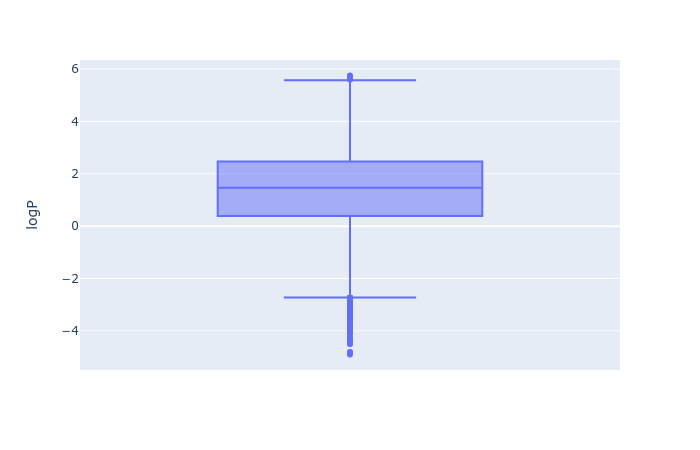

In [14]:
# Look at the logP distribution
fig = px.box(df, y="logP")
fig.show()
# looks quite reasonable. We won't need to filter on logP

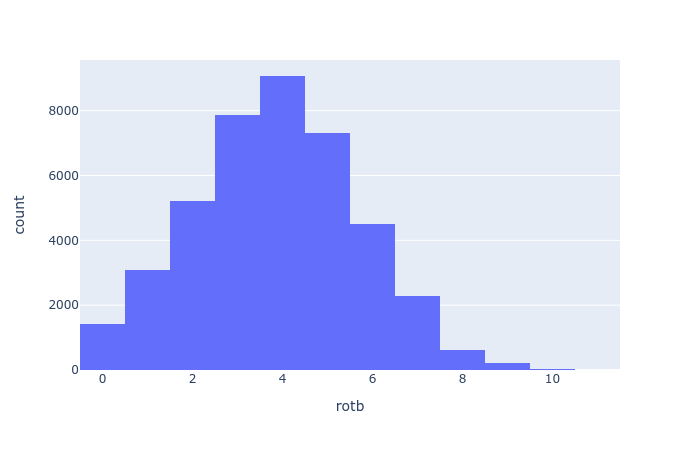

In [15]:
fig = px.histogram(df, x="rotb")
fig.show()
# a few with lots of rot bonds, but care needed as different tools have different ideas of what is a rotatable bond.
# Maybe we should filter out the highest.

## Incorporate supplier information 

In [17]:
with open('data/candidates/expanded-17.json') as f:
  expanded = json.load(f)
mols = expanded['results']
print(len(mols))

41587


In [18]:
# build a dict of suppliers keys by SMILES
suppliers_dict = {}
for mol in mols:
    # the values is a list of suplier codes
    suppliers_dict[mol['smiles']] = mol['vendorIds']
print(len(suppliers_dict))

41587


In [19]:
df['vendors'] = df['NSMILES'].apply(lambda smi: suppliers_dict[smi])
df.shape

(41582, 24)

## Incorporate data from Enalos

In [20]:
df_enalos = pd.read_csv('data/enalos/16/Enalos_data_41k.csv.gz')
df_enalos.dtypes

ID                               int64
original SMILES                 object
SMILES                          object
InChI                           object
InChIkey                        object
Cytotoxicity_Classification     object
Cytotoxicity_Prediction         object
MSlogBCF_Regression            float64
MSlogBCF_Prediction             object
MSlogBP_Regression             float64
MSlogBP_Prediction              object
MSlogP_Regression              float64
MSlogP_Prediction               object
MSlogS_Regression              float64
MSlogS_Prediction               object
MSlogVP_Regression             float64
MSlogVP_Prediction              object
Mutagenicity_Classification     object
Mutagenicity_Prediction         object
dtype: object

In [21]:
df_enalos = df_enalos.drop(columns=['ID','SMILES', 'InChI', 'InChIkey'])
df_enalos.head()

,original SMILES,Cytotoxicity_Classification,Cytotoxicity_Prediction,MSlogBCF_Regression,MSlogBCF_Prediction,MSlogBP_Regression,MSlogBP_Prediction,MSlogP_Regression,MSlogP_Prediction,MSlogS_Regression,MSlogS_Prediction,MSlogVP_Regression,MSlogVP_Prediction,Mutagenicity_Classification,Mutagenicity_Prediction
0,NC(=NO)NCCc1ccc(S(N)(=O)=O)cc1,"""inactive""",reliable,0.280563,reliable,321.906070,reliable,-1.148561,reliable,-2.199614,reliable,-8.858482,reliable,"""negative""",reliable
1,N/C(=N\O)NCc1ccc(S(N)(=O)=O)cc1,"""inactive""",reliable,0.329665,reliable,332.172738,reliable,-1.411587,reliable,-1.906268,reliable,-9.084317,reliable,"""negative""",reliable
2,N/C(=N\O)c1cccc(S(N)(=O)=O)c1,"""inactive""",reliable,0.325793,reliable,296.076828,reliable,-1.508278,reliable,-1.832074,reliable,-9.511909,reliable,"""negative""",reliable
3,NC(=NO)NCc1ccc(S(N)(=O)=O)cc1,"""inactive""",reliable,0.329665,reliable,332.172738,reliable,-1.411587,reliable,-1.906268,reliable,-9.084317,reliable,"""negative""",reliable
4,CC(CC(N)=NO)NC(C)c1ccccc1,"""active""",reliable,0.900143,reliable,295.527464,reliable,-0.607290,reliable,-1.693802,reliable,-7.715345,reliable,"""positive""",reliable


In [22]:
# Genrete bool columns for cytogenicity and mutagenicity where the prediction is reliable.
# Note that the values in the Cytotoxicity_Classification and Mutagenicity_Classification columns
# have double quotes around them. This is probably an artifact of how they were imported.

df_enalos['cytotox_bool'] = (df_enalos['Cytotoxicity_Classification'] == '"active"') & (df_enalos['Cytotoxicity_Prediction'] == 'reliable')
df_enalos['mutagen_bool'] = (df_enalos['Mutagenicity_Classification'] == '"positive"') & (df_enalos['Mutagenicity_Prediction'] == 'reliable')
df_enalos.dtypes

original SMILES                 object
Cytotoxicity_Classification     object
Cytotoxicity_Prediction         object
MSlogBCF_Regression            float64
MSlogBCF_Prediction             object
MSlogBP_Regression             float64
MSlogBP_Prediction              object
MSlogP_Regression              float64
MSlogP_Prediction               object
MSlogS_Regression              float64
MSlogS_Prediction               object
MSlogVP_Regression             float64
MSlogVP_Prediction              object
Mutagenicity_Classification     object
Mutagenicity_Prediction         object
cytotox_bool                      bool
mutagen_bool                      bool
dtype: object

In [23]:
df_enalos.head()

,original SMILES,Cytotoxicity_Classification,Cytotoxicity_Prediction,MSlogBCF_Regression,MSlogBCF_Prediction,MSlogBP_Regression,MSlogBP_Prediction,MSlogP_Regression,MSlogP_Prediction,MSlogS_Regression,MSlogS_Prediction,MSlogVP_Regression,MSlogVP_Prediction,Mutagenicity_Classification,Mutagenicity_Prediction,cytotox_bool,mutagen_bool
0,NC(=NO)NCCc1ccc(S(N)(=O)=O)cc1,"""inactive""",reliable,0.280563,reliable,321.906070,reliable,-1.148561,reliable,-2.199614,reliable,-8.858482,reliable,"""negative""",reliable,False,False
1,N/C(=N\O)NCc1ccc(S(N)(=O)=O)cc1,"""inactive""",reliable,0.329665,reliable,332.172738,reliable,-1.411587,reliable,-1.906268,reliable,-9.084317,reliable,"""negative""",reliable,False,False
2,N/C(=N\O)c1cccc(S(N)(=O)=O)c1,"""inactive""",reliable,0.325793,reliable,296.076828,reliable,-1.508278,reliable,-1.832074,reliable,-9.511909,reliable,"""negative""",reliable,False,False
3,NC(=NO)NCc1ccc(S(N)(=O)=O)cc1,"""inactive""",reliable,0.329665,reliable,332.172738,reliable,-1.411587,reliable,-1.906268,reliable,-9.084317,reliable,"""negative""",reliable,False,False
4,CC(CC(N)=NO)NC(C)c1ccccc1,"""active""",reliable,0.900143,reliable,295.527464,reliable,-0.607290,reliable,-1.693802,reliable,-7.715345,reliable,"""positive""",reliable,True,True


,NSMILES,Molecule,Target,TransFSScore,SCORE,SCORE.norm,Max_SuCOS_Score,Max_SuCOS_FeatureMap_Score,Max_SuCOS_Protrude_Score,Max_SuCOS_Index,...,MSlogP_Regression,MSlogP_Prediction,MSlogS_Regression,MSlogS_Prediction,MSlogVP_Regression,MSlogVP_Prediction,Mutagenicity_Classification,Mutagenicity_Prediction,cytotox_bool,mutagen_bool
0,BrC(Br)=Cc1ccc(Br)cc1,,678.sdf.gz,0.162173,-14.4733,-1.31576,0.000000,0.000000,0.000000,0,...,3.163015,reliable,-3.555276,reliable,-2.627146,reliable,"""positive""",reliable,False,True
1,BrC(Br)=Cc1ccncn1,,104.sdf.gz,0.078375,-30.9106,-3.09106,0.284089,0.024352,0.543826,13,...,1.714203,reliable,-1.546453,reliable,-1.888550,reliable,"""positive""",reliable,False,True
2,BrC(Br)=Cc1cncnc1,,104.sdf.gz,0.076633,-33.4132,-3.34132,0.317920,0.179804,0.456035,2,...,1.565949,reliable,-1.691761,reliable,-1.888041,reliable,"""positive""",reliable,False,True
3,BrC(CCC1CCCCC1)Cc1ccccn1,,249.sdf.gz,0.178053,-15.4443,-0.90849,0.434434,0.151883,0.716986,13,...,4.696016,reliable,-4.416978,reliable,-4.291090,reliable,"""negative""",reliable,False,False
4,BrC(CCC1CCCCC1)Cc1ccncc1,,678.sdf.gz,0.431011,-23.7233,-1.39549,0.308991,0.099810,0.518171,8,...,4.281094,reliable,-3.973919,reliable,-3.693665,reliable,"""negative""",reliable,False,False

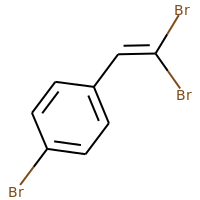
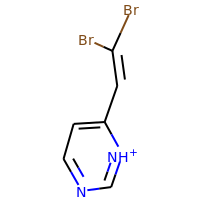
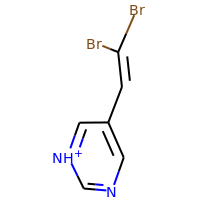
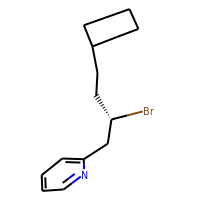
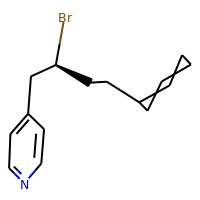

In [24]:
df_merged_enalos = pd.merge(df, df_enalos, left_on='NSMILES', right_on='original SMILES')
df_merged_enalos.head()

TODO - analyse the Enalos data

## Incorporate Learning Ligand data

In [25]:
df_learning_ligand = PandasTools.LoadSDF('final_scored_agg.sdf', molColName='Molecule')
df_learning_ligand.dtypes

CHROM.0                                           object
CHROM.1                                           object
Cum_SuCOS_FeatureMap_Score                        object
Cum_SuCOS_Protrude_Score                          object
Cum_SuCOS_Score                                   object
                                                   ...  
score_Target-blindtrainingset_RF-Scorev3-RDKit    object
score_Target-blindtrainingset_Vina                object
score_Target-blindtrainingset_Vina-RDKit          object
ID                                                object
Molecule                                          object
Length: 78, dtype: object

In [26]:
columns_to_remove = ['CHROM.0', 'CHROM.1', 'RI', 'Rbt.Current_Directory', 'Rbt.Executable', 'Rbt.Library', 
                     'Rbt.Parameter_File', 'Rbt.Receptor', 'Name', 'SCORE.INTER', 'SCORE.INTER.CONST',
                     'SCORE.INTER.POLAR', 'SCORE.INTER.REPUL', 'SCORE.INTER.ROT', 'SCORE.INTER.VDW',
                     'SCORE.INTER.norm', 'SCORE.INTRA', 'SCORE.INTRA.DIHEDRAL', 'SCORE.INTRA.DIHEDRAL.0',
                     'SCORE.INTRA.POLAR', 'SCORE.INTRA.POLAR.0', 'SCORE.INTRA.REPUL', 'SCORE.INTRA.REPUL.0',
                     'SCORE.INTRA.VDW', 'SCORE.INTRA.VDW.0', 'SCORE.INTRA.norm', 'SCORE.RESTR',
                     'SCORE.RESTR.norm', 'SCORE.SYSTEM', 'SCORE.SYSTEM.CONST', 'SCORE.SYSTEM.DIHEDRAL',
                     'SCORE.SYSTEM.POLAR', 'SCORE.SYSTEM.REPUL', 'SCORE.SYSTEM.VDW', 'SCORE.heavy',
                     'SCORE.SYSTEM.norm', 'TransFSReceptor', 'Name', 'Max_SuCOS_Cluster',
                     'Cum_SuCOS_FeatureMap_Score', 'Cum_SuCOS_Protrude_Score', 'Cum_SuCOS_Score',
                     'Max_SuCOS_FeatureMap_Score', 'Max_SuCOS_Index', 'Max_SuCOS_Protrude_Score',
                     'Max_SuCOS_Score', 'Protein_Target', 'SCORE', 'SCORE.norm', 'TransFSScore', 'Molecule'
                    ]
df_learning_ligand2 = df_learning_ligand.drop(columns=columns_to_remove)

df_learning_ligand2 = df_learning_ligand2.astype(dtype= {
    "score_Fulltrainingset_NNScore2.0":"float64",
    "score_Fulltrainingset_NNScore2.0-RDKit":"float64",
    "score_Fulltrainingset_RDKit":"float64",
    "score_Fulltrainingset_RF-Score":"float64",
    "score_Fulltrainingset_RF-Score-RDKit":"float64",
    "score_Fulltrainingset_RF-Scorev3":"float64",
    "score_Fulltrainingset_RF-Scorev3-RDKit":"float64",
    "score_Fulltrainingset_Vina":"float64",
    "score_Fulltrainingset_Vina-RDKit":"float64",
    "score_Target-awaretrainingset_NNScore2.0":"float64",
    "score_Target-awaretrainingset_NNScore2.0-RDKit":"float64",
    "score_Target-awaretrainingset_RDKit":"float64",
    "score_Target-awaretrainingset_RF-Score":"float64",
    "score_Target-awaretrainingset_RF-Score-RDKit":"float64",
    "score_Target-awaretrainingset_RF-Scorev3":"float64",
    "score_Target-awaretrainingset_RF-Scorev3-RDKit":"float64",
    "score_Target-awaretrainingset_Vina":"float64",
    "score_Target-awaretrainingset_Vina-RDKit":"float64",
    "score_Target-blindtrainingset_NNScore2.0":"float64",
    "score_Target-blindtrainingset_NNScore2.0-RDKit":"float64",
    "score_Target-blindtrainingset_RDKit":"float64",
    "score_Target-blindtrainingset_RF-Score":"float64",
    "score_Target-blindtrainingset_RF-Score-RDKit":"float64",
    "score_Target-blindtrainingset_RF-Scorev3":"float64",
    "score_Target-blindtrainingset_RF-Scorev3-RDKit":"float64",
    "score_Target-blindtrainingset_Vina":"float64",
    "score_Target-blindtrainingset_Vina-RDKit":"float64"
})

df_learning_ligand2.dtypes

score_Fulltrainingset_NNScore2.0                  float64
score_Fulltrainingset_NNScore2.0-RDKit            float64
score_Fulltrainingset_RDKit                       float64
score_Fulltrainingset_RF-Score                    float64
score_Fulltrainingset_RF-Score-RDKit              float64
score_Fulltrainingset_RF-Scorev3                  float64
score_Fulltrainingset_RF-Scorev3-RDKit            float64
score_Fulltrainingset_Vina                        float64
score_Fulltrainingset_Vina-RDKit                  float64
score_Target-awaretrainingset_NNScore2.0          float64
score_Target-awaretrainingset_NNScore2.0-RDKit    float64
score_Target-awaretrainingset_RDKit               float64
score_Target-awaretrainingset_RF-Score            float64
score_Target-awaretrainingset_RF-Score-RDKit      float64
score_Target-awaretrainingset_RF-Scorev3          float64
score_Target-awaretrainingset_RF-Scorev3-RDKit    float64
score_Target-awaretrainingset_Vina                float64
score_Target-a

,NSMILES,Molecule,Target,TransFSScore,SCORE,SCORE.norm,Max_SuCOS_Score,Max_SuCOS_FeatureMap_Score,Max_SuCOS_Protrude_Score,Max_SuCOS_Index,...,score_Target-awaretrainingset_Vina-RDKit,score_Target-blindtrainingset_NNScore2.0,score_Target-blindtrainingset_NNScore2.0-RDKit,score_Target-blindtrainingset_RDKit,score_Target-blindtrainingset_RF-Score,score_Target-blindtrainingset_RF-Score-RDKit,score_Target-blindtrainingset_RF-Scorev3,score_Target-blindtrainingset_RF-Scorev3-RDKit,score_Target-blindtrainingset_Vina,score_Target-blindtrainingset_Vina-RDKit
0,BrC(Br)=Cc1ccc(Br)cc1,,678.sdf.gz,0.162173,-14.4733,-1.31576,0.000000,0.000000,0.000000,0,...,5.887,5.825,6.209,6.159,5.054,5.996,5.568,5.909,5.930,6.192
1,BrC(Br)=Cc1ccncn1,,104.sdf.gz,0.078375,-30.9106,-3.09106,0.284089,0.024352,0.543826,13,...,5.041,4.625,5.117,5.531,4.148,5.410,4.481,5.336,4.146,5.410
2,BrC(Br)=Cc1cncnc1,,104.sdf.gz,0.076633,-33.4132,-3.34132,0.317920,0.179804,0.456035,2,...,4.950,4.511,5.020,5.602,4.096,5.427,4.499,5.277,4.315,5.401
3,BrC(CCC1CCCCC1)Cc1ccccn1,,249.sdf.gz,0.178053,-15.4443,-0.90849,0.434434,0.151883,0.716986,13,...,5.929,5.406,5.979,6.388,5.840,6.202,5.875,5.905,5.289,5.994
4,BrC(CCC1CCCCC1)Cc1ccncc1,,678.sdf.gz,0.431011,-23.7233,-1.39549,0.308991,0.099810,0.518171,8,...,5.862,5.400,6.090,6.427,5.716,6.271,5.579,6.019,5.356,6.085

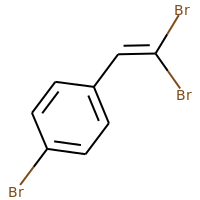
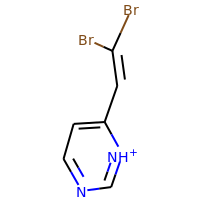
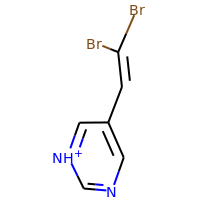
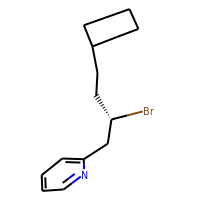
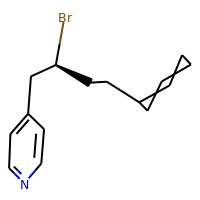

In [27]:
df_merged_learning_ligand = pd.merge(df_merged_enalos, df_learning_ligand2, left_on='NSMILES', right_on='ID')
df_merged_learning_ligand = df_merged_learning_ligand.drop(columns=['ID'])
df_merged_learning_ligand.head()

In [28]:
df_merged = df_merged_learning_ligand

# Filtering

Here is one approach to filtering.
We apply a series of filters to the data to be left with 'top scoring' molecules.
Beauty is in the eye of the beholder so try different filters.

The filters are applied in series.

**DO NOT** take this as an officially approved set of molecules for further consideration. This is work in progress.

In [29]:
df_merged.shape

(41576, 68)

In [30]:
# filter by TransFS score
df_merged = df_merged[df_merged['TransFSScore'] >= 0.9]
df_merged.shape

(6318, 68)

In [31]:
# filter out molecules that are too flexible
df_merged = df_merged[df_merged["rotb"] <= 6]
df_merged.shape

(5735, 68)

In [32]:
# filter by SuCOS score. Here we use Cum_SuCOS_Score but also consider using the 5 other SuCOS scores.
df_merged = df_merged[df_merged["Cum_SuCOS_Score"] >= 3]
df_merged.shape

(2256, 68)

In [33]:
# filter by normalised docking score. We use a pretty loose filter here as we know docking scores are not 
# that reliable, but we might as well throw out the ones that docking says are really bad. 
df_merged = df_merged[df_merged["SCORE.norm"] <= -1.0]
df_merged.shape

(1842, 68)

In [34]:
# remove molecules that are predicted to be cytotoxic and that prediction is reliable
df_merged = df_merged[df_merged["cytotox_bool"] == False]
df_merged.shape

(1431, 68)

In [35]:
# remove molecules that are predicted to be mutagenic and that prediction is reliable
df_merged = df_merged[df_merged["mutagen_bool"] == False]
df_merged.shape

(1263, 68)

In [36]:
# remove molecules with score_Target-awaretrainingset_RF-Scorev3-RDKit
df_merged = df_merged[df_merged['score_Target-awaretrainingset_RF-Scorev3-RDKit'] > 5]
df_merged.shape

(1063, 68)

We end up with 1063 molecules for further consideration.

As already mentioned, don't treat this as the definitve set of molecules to consider. It is just one way of going about it. 

In [37]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_merged.dtypes)

NSMILES                                            object
Molecule                                           object
Target                                             object
TransFSScore                                      float64
SCORE                                             float64
SCORE.norm                                        float64
Max_SuCOS_Score                                   float64
Max_SuCOS_FeatureMap_Score                        float64
Max_SuCOS_Protrude_Score                          float64
Max_SuCOS_Index                                     int64
Cum_SuCOS_Score                                   float64
Cum_SuCOS_FeatureMap_Score                        float64
Cum_SuCOS_Protrude_Score                          float64
distance1                                         float64
distance2                                         float64
distance3                                         float64
distance4                                         float64
distance5     

,NSMILES,Molecule,Target,TransFSScore,SCORE,SCORE.norm,Max_SuCOS_Score,Max_SuCOS_FeatureMap_Score,Max_SuCOS_Protrude_Score,Max_SuCOS_Index,...,score_Target-awaretrainingset_Vina-RDKit,score_Target-blindtrainingset_NNScore2.0,score_Target-blindtrainingset_NNScore2.0-RDKit,score_Target-blindtrainingset_RDKit,score_Target-blindtrainingset_RF-Score,score_Target-blindtrainingset_RF-Score-RDKit,score_Target-blindtrainingset_RF-Scorev3,score_Target-blindtrainingset_RF-Scorev3-RDKit,score_Target-blindtrainingset_Vina,score_Target-blindtrainingset_Vina-RDKit
115,C#CC(=O)Nc1cccc(S(N)(=O)=O)c1,,387.sdf.gz,0.907469,-22.1365,-1.47577,0.359799,0.076432,0.643165,3,...,6.657,4.823,5.322,5.538,4.671,5.302,5.118,5.262,5.052,5.441
144,C#CC(C)(C)Nc1ccccc1S(N)(=O)=O,,195.sdf.gz,0.968520,-21.7104,-1.35690,0.491637,0.346089,0.637186,6,...,5.953,5.238,5.521,5.871,5.967,5.636,5.485,5.558,5.095,5.502
270,C#CC(N)Cc1ccc(S(N)(=O)=O)cc1,,195.sdf.gz,0.980719,-20.2639,-1.35093,0.357789,0.063230,0.652348,11,...,6.771,5.259,5.691,6.134,5.507,5.753,5.457,5.618,4.598,5.658
276,C#CC(N)c1ccc(S(N)(=O)=O)cc1,,540.sdf.gz,0.965810,-20.6304,-1.47360,0.349753,0.176532,0.522973,13,...,6.447,5.203,5.594,5.793,5.045,5.453,5.133,5.429,4.662,5.509
357,C#CCC(=O)Nc1ccc(S(N)(=O)=O)cc1,,305.sdf.gz,0.930816,-19.2783,-1.20489,0.362836,0.025988,0.699684,3,...,6.462,5.681,5.492,5.550,4.969,5.294,5.357,5.435,5.844,5.460

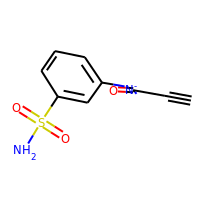
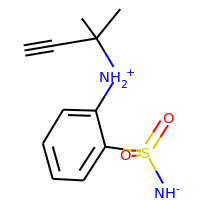
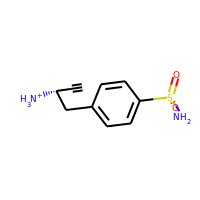
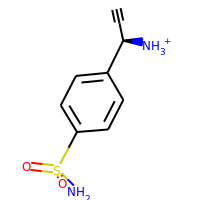
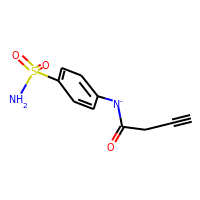

In [38]:
df_merged.head()